In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

c:\Users\PanCh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
num_classes = 10
image_dim = 28 * 28
batch_size = 128
num_epochs = 50
learning_rate = 0.0002

# Transform
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6465784.38it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 191138.42it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1649792.70it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4702673.11it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [3]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, image_dim):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, image_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], dim=1)
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, num_classes, image_dim):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(image_dim + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels)
        x = torch.cat([img, c], dim=1)
        return self.model(x)

In [4]:
# Initialize models
generator = Generator(latent_dim, num_classes, image_dim).to(device)
discriminator = Discriminator(num_classes, image_dim).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

In [5]:
# Training loop
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)
        real_imgs = imgs.view(batch_size, -1).to(device)
        labels = labels.to(device)
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        noise = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(noise, gen_labels)
        g_loss = criterion(discriminator(gen_imgs, gen_labels), real)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        real_loss = criterion(discriminator(real_imgs, labels), real)
        fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")

Epoch [1/50]  Loss D: 0.0008, Loss G: 7.4127
Epoch [2/50]  Loss D: 0.0048, Loss G: 5.6020
Epoch [3/50]  Loss D: 0.0675, Loss G: 8.0887
Epoch [4/50]  Loss D: 0.0473, Loss G: 6.6722
Epoch [5/50]  Loss D: 0.2848, Loss G: 5.0810
Epoch [6/50]  Loss D: 0.2059, Loss G: 3.0143
Epoch [7/50]  Loss D: 0.4889, Loss G: 2.1123
Epoch [8/50]  Loss D: 0.4684, Loss G: 1.9341
Epoch [9/50]  Loss D: 0.4282, Loss G: 3.0006
Epoch [10/50]  Loss D: 0.2967, Loss G: 2.4022
Epoch [11/50]  Loss D: 0.6103, Loss G: 5.1857
Epoch [12/50]  Loss D: 1.6185, Loss G: 1.3018
Epoch [13/50]  Loss D: 0.5203, Loss G: 2.0040
Epoch [14/50]  Loss D: 0.2899, Loss G: 3.5450
Epoch [15/50]  Loss D: 0.1849, Loss G: 2.8714
Epoch [16/50]  Loss D: 0.2044, Loss G: 3.0298
Epoch [17/50]  Loss D: 0.5058, Loss G: 4.2647
Epoch [18/50]  Loss D: 0.6499, Loss G: 3.1531
Epoch [19/50]  Loss D: 0.1727, Loss G: 4.7861
Epoch [20/50]  Loss D: 0.2981, Loss G: 3.0228
Epoch [21/50]  Loss D: 0.2772, Loss G: 3.5422
Epoch [22/50]  Loss D: 0.1387, Loss G: 4.92

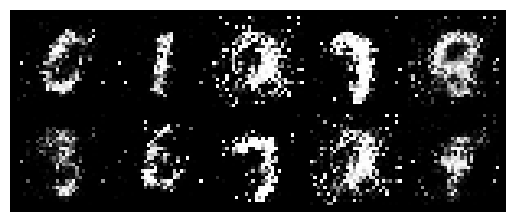

In [29]:
# Generate and visualize samples
noise = torch.randn(10, latent_dim).to(device)
labels = torch.arange(0, 10).to(device)
gen_imgs = generator(noise, labels).view(-1, 1, 28, 28).cpu().detach()
grid = torchvision.utils.make_grid(gen_imgs, nrow=5, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()